In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn-pastel')
import pandas as pd   # Works for pandas > v0.20
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 18,12

In [3]:
df = pd.read_csv("data/SampleSuperstore.csv")
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

# Univariate time series 
furniture_sales = furniture[['Order Date','Sales']]

# As read in as csv convert to date to datetime and make as the index
furniture_sales.sort_values('Order Date')
furniture_sales['Order Date'] = pd.to_datetime(furniture_sales['Order Date'])

# Sum the sales by date
furniture_sales = furniture_sales.groupby('Order Date')['Sales'].sum().reset_index()
furniture_sales = furniture_sales.set_index('Order Date')

# Create a monthly summary for EDA
furniture_sales_to_monthly = furniture_sales['Sales'].resample('MS').sum()

# Create a weekly set for predictions
furniture_sales_weekly = pd.DataFrame(furniture_sales['Sales'].resample('W').sum())

In [4]:
from sklearn.metrics import mean_squared_error
from pylab import rcParams
import math

def output_results(y_pred, full_dataset, title = 'Output Results', conf_int = []):
    
    y_values = y_pred # .predicted_mean
    
    fig = plt.figure()
    
    train_len = len(full_dataset) - len(y_values)
    
    rcParams['figure.figsize'] = 18,12
    
    rmse = math.sqrt(mean_squared_error(full_dataset[train_len:], y_values))
    title = title + ' - RMSE: {}'.format(str(round(rmse, 2)))    
    
    plt.xlabel('Date - Week Commencing')
    plt.ylabel('Sales')
    plt.plot(full_dataset[train_len:].index, y_values, label ='One Step Forecast', color = 'red')
    plt.plot(full_dataset[:train_len].index, full_dataset[:train_len], label = 'Training', color = 'blue')
    plt.plot(full_dataset[train_len:].index, full_dataset[train_len:], label = 'Observed', color = 'grey')
    plt.legend()
    
    if len(conf_int):
        plt.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='k', alpha=.2)
        
    
    fig.suptitle(title, fontsize=16)
    
    return plt, rmse

In [5]:
def shift_dataset(df, column_name, lags):
    
    for each_lag in range(1,lags + 1):
        
        new_col = column_name + '_' + str(each_lag)
        df[new_col] = df[column_name].shift(each_lag)
        
    
    df.dropna(inplace = True)
    
    return df
        

In [6]:
def split_data(df, train_split = 0.8):

    train_len = int(len(df) * train_split)

    train_data = df[:train_len]
    test_data = df[train_len:]

    y_train = train_data['Sales']
    X_train = train_data.drop(['Sales'], axis = 1)

    y_test = test_data['Sales']
    X_test = test_data.drop(['Sales'], axis = 1)

    X_all = df.drop(['Sales'], axis = 1)
    y_all = df['Sales']
    
    return X_all, y_all, X_train, y_train, X_test, y_test

In [54]:
lags = 50

df_copy = furniture_sales_weekly.copy()

df_shift = shift_dataset(df_copy, 'Sales', lags)
X_all, y_all, X_train, y_train, X_test, y_test = split_data(df_shift, 0.8)


In [55]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [56]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X_train.values.reshape((X_train.shape[0],lags, n_features))

In [57]:
# fit model
model.fit(X, y_train, epochs=200, verbose=0)

In [58]:
x_input = X_test.values.reshape((X_test.shape[0], lags, n_features))
y_pred = model.predict(x_input, verbose=0)

In [59]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_test, y_pred))

2253.2680378054506

(<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 2253.2680378054506)

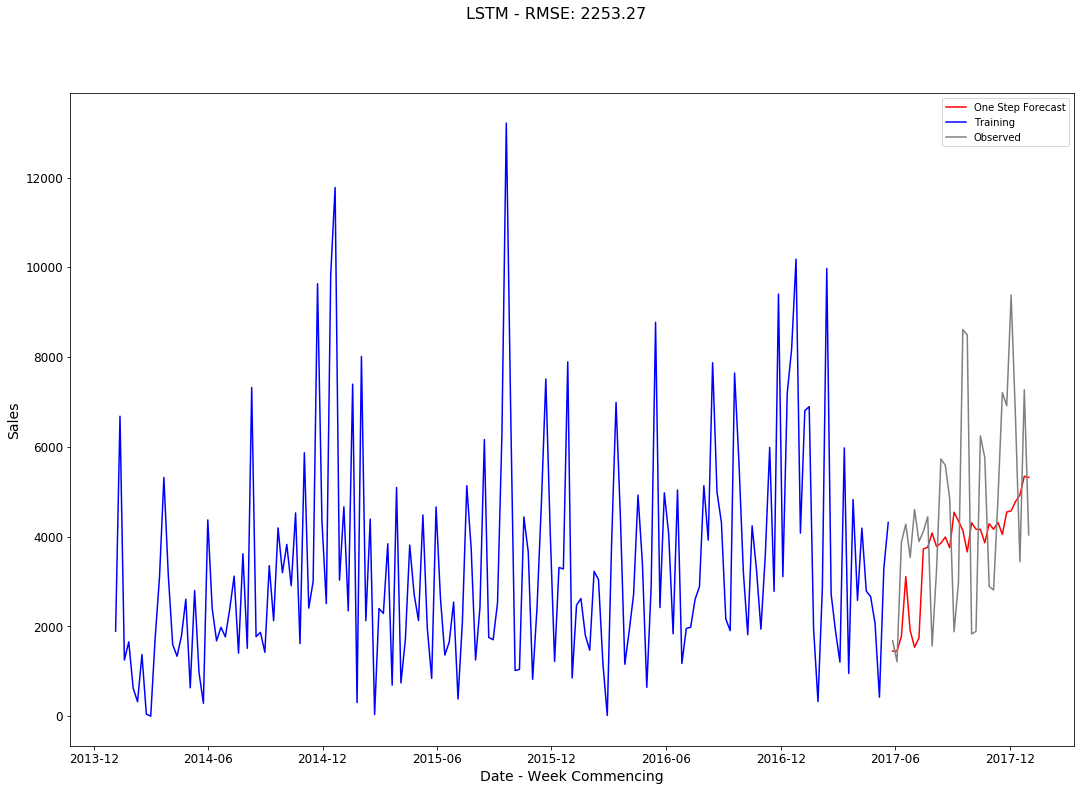

In [60]:
rcParams['figure.figsize'] = 18,12
output_results(y_pred, furniture_sales_weekly, title = 'LSTM')